# Lesson 4 Batch Processing and Tracking

Congratulations, you've just completed an awesome image processing pipeline that takes an image and does something rather useful. You've tested it a few times and you're happy with the results. 

Now maybe you need to apply the same operation to 1000 images. Maybe you need to apply them to 20 datasets with slightly different parameters. Maybe you need to aggregate information across the results of each processed image to make your conclusions. These needs can be addressed by applying your pipeline with batch processing. In this lesson, you will learn:

1. Two batch processing strategies and their advantages & disadvantages
2. Cell tracking approach and measurements


## 4.1 Batch processing strategies (vertical and horizontal integration)

### 4.1.1 Project aim: batch processing of multiple images

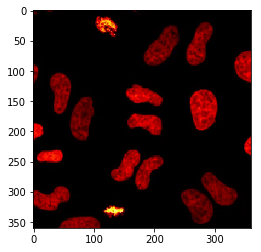

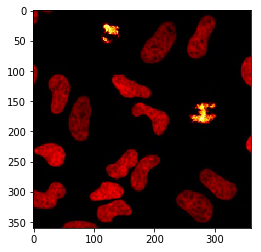

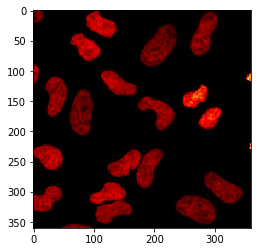

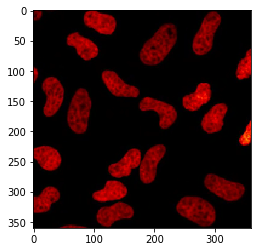

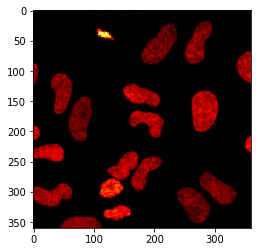

In [130]:
data_folder = "C:/Users/Andy/Desktop/images2018/data/batch_tracking"

import os
from skimage.io import imread
import matplotlib.pyplot as plt

os.chdir(data_folder)
listdir = os.listdir
files = [f for f in os.listdir(data_folder) if '.tif' in f]

for f in files:
    img = imread(f)
    plt.figure()
    plt.imshow(img)

**Exercise** You're at the point where you have the functions below. How might you apply the pipeline you developed to every image in a folder, saving the results in a list?

In [131]:
def loading(image_file_name):
    img = imread(image_file_name)
    return img

def preprocessing(image):
    process_image = None
    return process_image

def info_extraction(image):
    results = None
    return results


### 4.1.2 Strategy one: the vertical approach

#### A straightforward procedure that applies all processing steps to each image one at a time, from start to end.

In [132]:
results = []
for f in files:
    img = loading(f)
    processed = preprocessing(img)
    result = info_extraction(processed)
    results.append(result)

#### Example: counting cell numbers from 5 images

In [187]:
# define functions

from skimage.io import imread
def loading(image_file_name):
    img = imread(image_file_name)
    return img[:,:,0]

import numpy as np
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm
def preprocessing(image):
    # filtering
    filtered = median_filter(image, size=2) 
    # thresholding
    otsu_thresh = filters.threshold_otsu(filtered) 
    masked = filtered > otsu_thresh*0.85 #smaller threshold than otsu      
    # morphology
    morph = sm.binary_opening(masked,sm.disk(3)) 
    return morph

from skimage.measure import label
from skimage.measure import regionprops
import matplotlib.pyplot as plt
def info_extraction(image):
    # labeling
    cell_labels = label(image)
    cell_number = np.amax(cell_labels)
    plt.figure() 
    plt.imshow(cell_labels)
    return cell_number 

Cell Numbers in Each Image: [21, 23, 21, 22, 20]


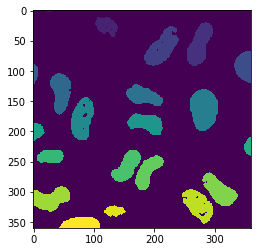

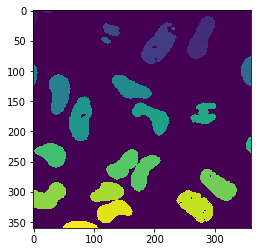

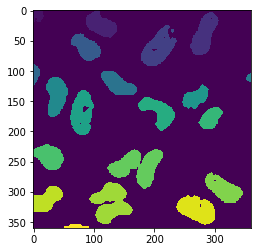

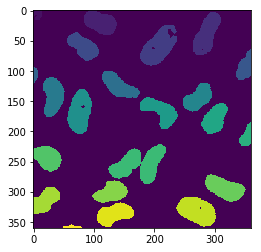

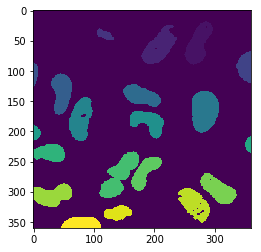

In [188]:
# batch processing

results = []
for f in files:
    img = loading(f)
    processed = preprocessing(img)
    tmp_result = info_extraction(processed)
    results.append(tmp_result)
    
print('Cell Numbers in Each Image:',results)

In this vertical pipeline, we converted different steps as different functions. Its advantages include: 
##### 1) Concise flow: clear main flow for coding, reading, and management; 
##### 2) No side effect: local parameter changes inside  the function won't affect the global parameters in the main flow; 
##### 3) Time saving: easily reused for other projects; 
##### 4) Reproducible:minimal input error or inconsistent operation. 

These are very important when processing large dataset with multiple steps, especially with many lines of codes.

#### Example: understand the importance of predefined function
    
["imread" function: source codes](https://github.com/luispedro/imread/blob/master/imread/imread.py)

### 4.1.3 Strategy two: horizontal approach
But, if you face a problem and want to debug suspicious functions, vertical approach may not be the best choice. 
Instead of applying all processing steps to each image one at a time, you can apply each processing step to each image. In this way, each function will serve as a seperate unit for testing and debugging.

Cell Numbers in Each Image: [21, 23, 21, 22, 20]


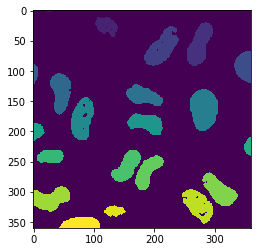

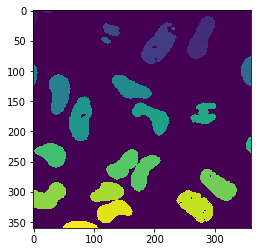

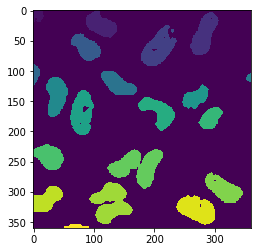

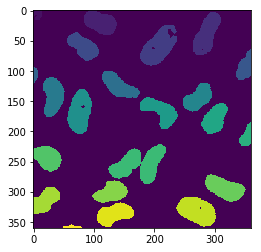

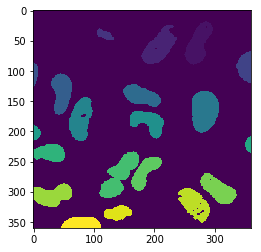

In [183]:
images = []
processed = []
results = []

for f in files:
    images.append(loading(f))
    
for img in images:
    processed.append(preprocessing(img))
    
for proc in processed:
    results.append(info_extraction(proc))

print('Cell Numbers in Each Image:',results)

So now rather than completing your pipline "vertically", from start to finish, top to bottom, you are completing your pipeline "horizontally", applying each stage across the board in sequence.

In fact, when you've made your code modular with little functions, Python tries to support this approach with _functional programming tools_. We'll talk about one of the especially useful ones:

- `map(function, iterable)`. Applies `function` to each element in `iterable` (i.e. anything you can loop through) and gives you a new list with the results.

Cell Numbers in Each Image: [21, 23, 21, 22, 20]


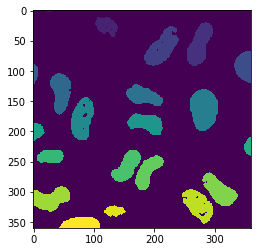

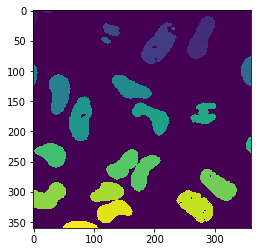

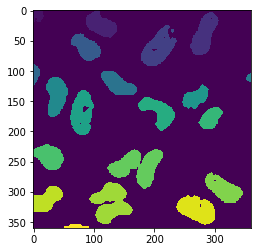

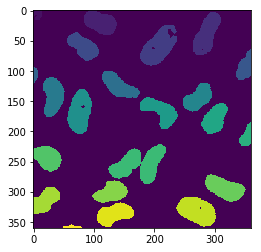

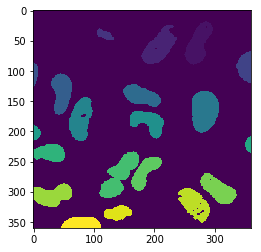

In [184]:
images = map(loading, files)
processed = map(preprocessing,images)
results = map(info_extraction, processed)

print('Cell Numbers in Each Image:',list(results))

Now this looks like a pretty concise way to process a pipeline! But is it the best way?

### 4.1.4 Memory cost for batch processing


One thing to consider is that at the end of the program, `files`, `images`, `processed`, and `results` are all full arrays available to you in program memmory. This could be useful for debugging (did everything look good after preprocessing?). It may also be useful because you need to aggregated across intermediate results. Maybe you only want to use images where the background level is $\pm 10\%$ of the median across all images in your experiment (if Otsu's method sets the background threshold very high or low, it's suspicious).

The downside of having all the intermediate information is that it may use a lot of memory.

**Exercise** Not all approaches above are as memory intensive as the others. Which approach is the least offensive?

**Exercise** in our lesson on loading an image we discussed how much memory an image can use up. If you are processing 1000 16-bit, 1024x1024 pixel images each with 3 channels, how much memory does the first line above use?

In [185]:
num_bytes = 1000 * 2 * 1024**2 * 3
print("{} Bytes".format(num_bytes))
print("{} GB".format(num_bytes / 1024.**3))

6291456000 Bytes
5.859375 GB


That's probably not going to go smoothly if you have a multi-stage pipeline. You could delete each stage as you go, keeping in memory only the last and current stage using `del` stagements, e.g. `del images`, but this can introduce bugs when you need some parameters later. For very large numbers of images, this strategy suffers.

In [186]:
processed = map(preprocessing,images)
del images

list(images)

NameError: name 'images' is not defined

A good way to design a pipeline is to draw out the pipes. Map out the dependencies between pieces of information so you can see where to break things into functions and figure out how much data you actually need to keep in memory. The example below is a workflow for processing a green structural channel and a red calcium fluorescence channel in a 60-frame time series of images. The goal is to find cells, make masks, and track the fluorescence intensities over time.

![Diagram of a pipeline](pipeline_diagrams.png "A typical pipeline diagram")

What are some observations we can make once we've drawn out this plan? We can see that loading raw images and preprocessing them can be done with one function, applied image-by-image, without saving the intermediate. However we need to stop after this and max project. We can then remove all of the green channel data from memory and work on the red channel, keeping only the cell location masks. We then apply the cell location masks to each image, one at a time, take out resulting total cell intensities and save them in an array.

Without doing this, we may have tried to load both channels at the beginning, which will double our memory consumption.

---------------------------------------------------------------------------------------------------------------------

# 4.2 Tracking objects / pipeline design

It is important to be able to order the various image processing tools you have learnt in an automated pipeline so you don't have to apply the same N transformations over and over again to your dataset of M images. Today wou will learn how to build your very own image processing pipeline, along with some nifty video processing tools.

We will do this in the context of an image processing method known as "tracking". You already know how to identify separate objects in your images and measure their properties (position, size, intensity etc.). Now imagine you have a time-series of images (or a video...). Tracking is essentially the ability to identify the same object in your entire time-series consistently. We will also demonstrate how this process can fail, and what to watch out for when you are analyzing your own data.


In [101]:
from moviepy import editor as mpy

vid_file_name = "C:/Users/Andy/Desktop/images2018/data/batch_tracking/CellVideo.mp4"
vid = mpy.VideoFileClip(vid_file_name)
mpy.ipython_display(vid, width=480)

100%|█████████████████████████████████████████| 45/45 [00:00<00:00, 371.89it/s]


In [110]:
import numpy as np
from scipy.ndimage.filters import median_filter
from skimage import filters
import skimage.morphology as sm
def preprocessing(image):
    # filtering
    filtered = median_filter(image, size=2) 
    # thresholding
    otsu_thresh = filters.threshold_otsu(filtered) 
    masked = filtered > otsu_thresh-15 #smaller threshold than otsu      
    # morphology
    morph = sm.binary_erosion(masked,sm.disk(1)) 
    return morph

from skimage.measure import label
from skimage.measure import regionprops
def info_extraction(image):
    # labeling
    cell_labels = label(image)
    props = regionprops(cell_labels)
    return props, cell_labels

In [ ]:
from scipy.spatial import distance
import math
def update_centroid(frame_num, cell_position, props):
    # centroid of the chosen cell in the previous frame
    p0 = cell_position[frame_num-1, :] 
    # calculate the distances of all cell centers in current frame to the chosen cell centroid in previous frame
    cell_num = len(props)
    pt_dist = np.zeros((cell_num, 1))
    for i in range(cell_num): 
        p1 = props[i].centroid
        pt_dist[i] = math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
    # decide the nearest cell centroid in current frame to the chosen cell centroid in the previous frame
    min_ind = np.argmin(pt_dist)
    # update the nearest centroid as the centroid of chosen cell in the current frame
    cell_position[frame_num,:] = props[min_ind].centroid
    return cell_position

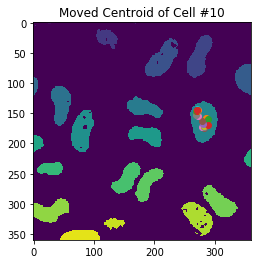

In [115]:
import matplotlib.pyplot as plt

num_frames = len(list(vid.iter_frames()))
cell_position = np.zeros((num_frames, 2))

for frame_num, frame in enumerate(vid.iter_frames()): 
    
    # preprocessing and cell labeling
    img = frame[:,:,0]
    processed = preprocessing(img)
    [props, cell_labels] = info_extraction(processed)
    
    # decide the centroid of cell#10 in the first frame
    if frame_num==0:
        cell_position[frame_num,:] = props[10].centroid
        plt.imshow(cell_labels) 
        
    #decide the centroid of cell#10 in current frame (nearest to the one in the prvious frame)
    else: 
        cell_position = update_centroid(frame_num, cell_position, props)  
        
        plt.plot(cell_position[frame_num,1],cell_position[frame_num,0], 'o')
        plt.title('Moved Centroid of Cell #10')

Text(0.5,1,'Cell Centroid Position: pixels')

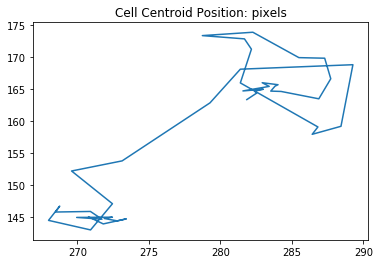

In [112]:
plt.plot(cell_position[:,1], cell_position[:,0])
plt.title('Cell Centroid Position: pixels')

Text(0.5,1,'Motion Distance: pixels')

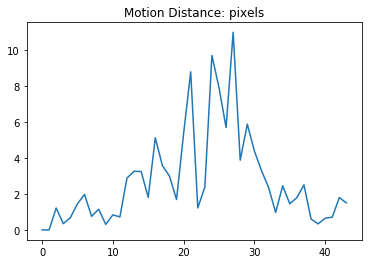

In [113]:
frameNum = len(cell_position)
cell_distance = np.zeros(frameNum-1)

for nframe in range(1,frameNum-1):
    x1 = cell_position[nframe-1,0]
    y1 = cell_position[nframe-1,1]
    x2 = cell_position[nframe,0]
    y2 = cell_position[nframe,1]
    
    cell_distance[nframe]= math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    
plt.plot(cell_distance)
plt.title('Motion Distance: pixels')